In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Attractant Dynamics Parameters

This notebook allows you to expermiment with how different attractant dynamics parameters create different levels of observed bias in different points in space and time. The model goes something like this:

The heat equation gives us a solution to calculate the concentration of attractant at any point $r$ and $t$ in space. It takes parameters $q$, $D$ and $\tau$, which represent the flow rate, the diffusion coefficient and the diffusion time respectively. This is then used, along with the theory of receptir-lingand binding kinetics, to predict the number of bound complexes that should appear on either side of a migrating leukocyte. This equation takes parameters $R_0$ and $\kappa_d$. Finally, the observed bias of a cell at time $t$ a distance $r$ from the wound is assumed to be linearly related to the difference between the concentration of bound receptors at the front and rear of the cell. 

This means, given a set of parameters $\theta = \{q, \, D, \, \tau, \, R_0, \, \kappa_d, \, m, \, b_0\}$, we can calculate the observed bias one would expect to occur at any point in space and time. 



In [9]:
# allow imports from the LM package
import os
import sys
sys.path.append(os.path.abspath('..'))

In [10]:
from inference.attractant_inference import AttractantInferer, observed_bias
from in_silico.sources import CellsOnWoundMargin, PointWound, CellsInsideWound
from utils.distributions import Normal

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [12]:
from ipywidgets import interact
%matplotlib notebook

In [13]:
# update functions for the plot

def update_y():
    
    for scat, line, tt in zip(scats, lines, t):
        line.set_ydata(observed_bias(params, r, tt, wound))
        scat.set_ydata(observed_bias(params, r_points, tt, wound))
        
def update_q(q=500):
    params[0] = q
    update_y()
    
def update_D(D=300):
    params[1] = D
    update_y()
    
def update_tau(tau=30):
    params[2] = tau
    update_y()
    
def update_R0(R0=0.2):
    params[3] = R0
    update_y()
    
def update_kappa(kappa=0.1):
    params[4] = kappa
    update_y()
    
def update_m(m=3):
    params[5] = m
    update_y()
    
def update_b0(b0=0.001):
    params[6] = b0
    update_y()

## Observed bias: a point wound

<IPython.core.display.Javascript object>


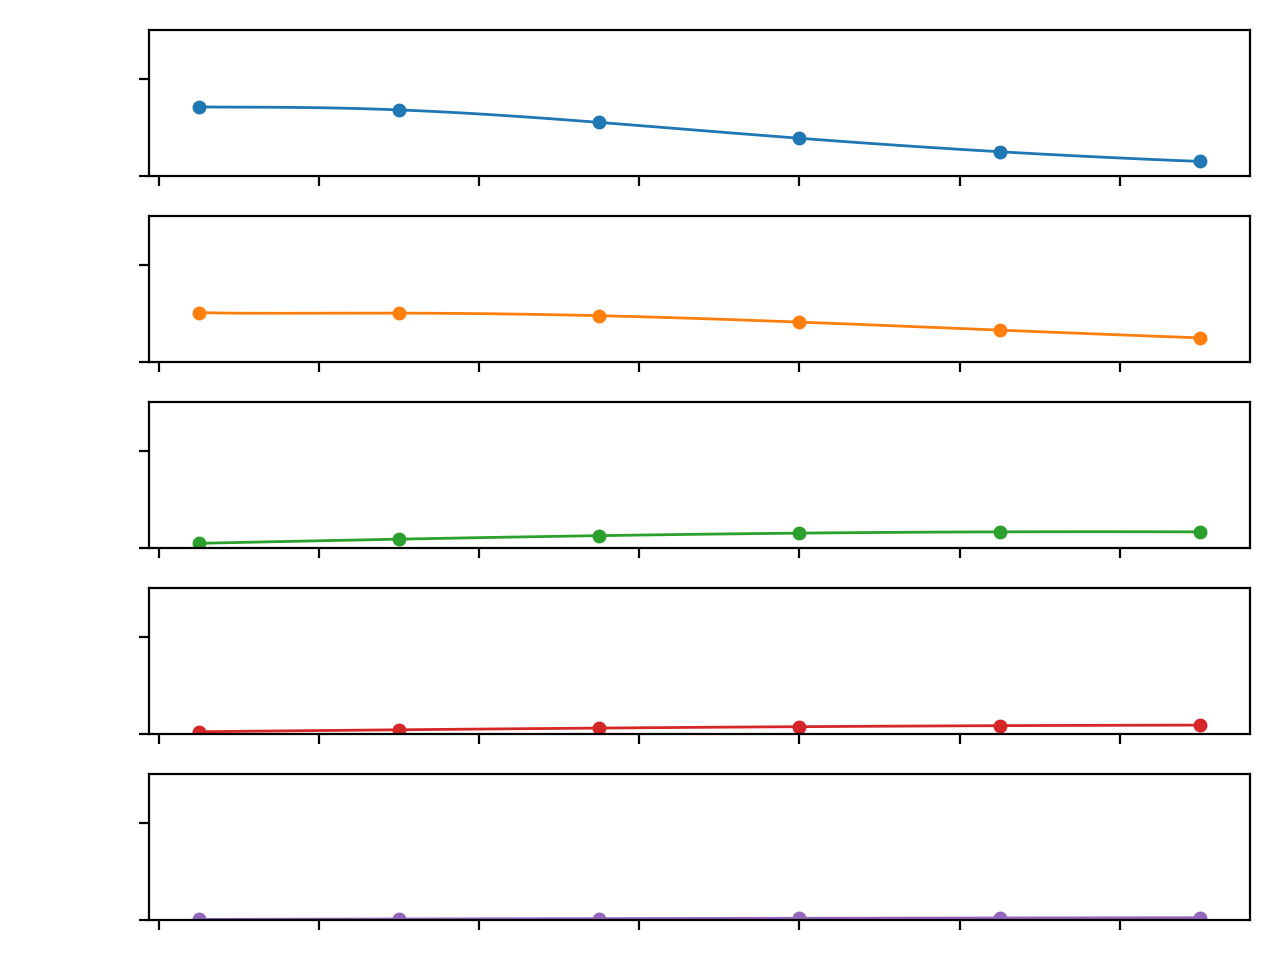

/Users/danieltudor/Documents/ImmuneCellMigrationAnalysis/in_silico/sources.py:361: RuntimeWarning: divide by zero encountered in true_divide
  out = expi(- r ** 2 / (4 * D * (t - tau))) - expi(- r ** 2 / (4 * D * t))
/Users/danieltudor/Documents/ImmuneCellMigrationAnalysis/in_silico/sources.py:361: RuntimeWarning: divide by zero encountered in true_divide
  out = expi(- r ** 2 / (4 * D * (t - tau))) - expi(- r ** 2 / (4 * D * t))


interactive(children=(IntSlider(value=500, description='q', max=1000, min=1), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=300, description='D', max=1000, min=1), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=30, description='tau'), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.2, description='R0', max=1.0, step=0.001), Output()), _dom_classes=(…

interactive(children=(FloatSlider(value=0.1, description='kappa', max=1.0, step=0.001), Output()), _dom_classe…

interactive(children=(FloatSlider(value=3.0, description='m', max=10.0, step=0.01), Output()), _dom_classes=('…

interactive(children=(FloatSlider(value=0.001, description='b0', max=0.01, step=0.0001), Output()), _dom_class…

In [14]:
q = 500
D = 300
tau = 30
R0 = 0.2
kappa = 0.1
m = 3
b0 = 0.001
params = np.array([q, D, tau, R0, kappa, m, b0])

fig, axes = plt.subplots(ncols=1, nrows=5, sharex=True)
    
# instantiate a point wound
wound = PointWound(position=np.array([0, 0]))

# where to measure observed bias
r_points = np.array([25, 50, 75, 100, 125, 150])
r = np.linspace(25, 150, 100)
t = np.array([15, 30, 45, 60, 120])

for ax, p in zip(axes, t):
    ax.set_ylabel('$t={}$'.format(p), rotation=0, size='large', labelpad=35)

# plot the points 
lines = []
scatters = []
for i, tt in enumerate(t):
    col = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    lines.append(axes[i].plot(r, observed_bias(params, r, tt, wound), color=col, linewidth=1)[0])
    scatters.append(axes[i].plot(r_points, observed_bias(params, r_points, tt, wound), color=col, marker='o', linewidth=0, markersize=4)[0])
    axes[i].set_ylim(0, 0.3)

axes[0].set_title('A point wound: observed bias as a function of distance')
axes[-1].set_xlabel('Distance, microns')
plt.tight_layout()

# use interactive sliders to change the parameters    
interact(update_q, q=(1, 1000, 1));
interact(update_D, D=(1, 1000, 1));
interact(update_tau, tau=(0, 100, 1));
interact(update_R0, R0=(0, 1, 0.001));
interact(update_kappa, kappa=(0, 1, 0.001));
interact(update_m, m=(0, 10, 0.01));
interact(update_b0, b0=(0, 0.01, 0.0001));

# We can now use the observed bias readings at these specific points in space and time to try and infer back the attractant dynamics parameters

In [15]:
# get the observed bias readings from the sliders graph. 
# ob_readings is a dictionary containing {(r, t): mu, sig} where mu and sig are the observed bias mean and standard deviation at the point r and time t

ob_readings = {}
for T, ob in zip(t, scatters):
    mus = ob.get_ydata()
    rs = ob.get_xdata()
    for r, mu in zip(rs, mus):
        ob_readings[(r, T)] = (mu, 0.02)
        
ob_readings

{(25, 15): (0.1423007161482891, 0.02),
 (50, 15): (0.1360834003933324, 0.02),
 (75, 15): (0.11047967954943605, 0.02),
 (100, 15): (0.07801911308994117, 0.02),
 (125, 15): (0.0503578174372486, 0.02),
 (150, 15): (0.030468661911072642, 0.02),
 (25, 30): (0.10189915649427037, 0.02),
 (50, 30): (0.1007361422695835, 0.02),
 (75, 30): (0.09551311770379994, 0.02),
 (100, 30): (0.08239722508302758, 0.02),
 (125, 30): (0.06597399594557898, 0.02),
 (150, 30): (0.05009990334743106, 0.02),
 (25, 45): (0.010151512643212263, 0.02),
 (50, 45): (0.018673969800649726, 0.02),
 (75, 45): (0.025873959156764076, 0.02),
 (100, 45): (0.031046866700810333, 0.02),
 (125, 45): (0.033671972343955525, 0.02),
 (150, 45): (0.03363551019678013, 0.02),
 (25, 60): (0.005210379038746409, 0.02),
 (50, 60): (0.00919072653520886, 0.02),
 (75, 60): (0.012718945029046996, 0.02),
 (100, 60): (0.015594521024744068, 0.02),
 (125, 60): (0.017659480595215465, 0.02),
 (150, 60): (0.01882218830195223, 0.02),
 (25, 120): (0.0018331

In [ ]:
inferer = AttractantInferer(ob_readings, wound=wound, t_units='minutes')
out1 = inferer.multi_infer(n_walkers=5,
                            n_steps=500000, 
                            burn_in=300000, 
                            seed=0,
                            suppress_warnings=True, 
                            use_tqdm=True)

Beginning MCMC walk in parallel


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(12, 5), sharex='col')
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

names = ['$q$ [mol min$^{-1}$]', '$D$ [$\mu m^{2}$ min$^{-1}$]', 'τ [min]', '$R_0$ [mol $\mu m^{-2}$]', '$\kappa_d$ [mol $\mu m^{-2}$]', '$m$ [$\mu m^{2}$ mol$^{-1}$]', '$b_0$ [unitless]']

for j in range(7):
    
        axes[j].set_title(names[j])
        axes[j].set_yticks([])
        axes[j].hist(out1[:, j], bins=50, color=cols[j], alpha=0.6, density=True)
        inferer.priors[j].plot(ax=axes[j], color=cols[j])
        
plt.tight_layout()